## This is a heap of almost every analysis and visualization we've done to get a feel of the data. It's not pretty because we don't have much time but it gives a general sense of our workflow.

Many of the visualizations from here can be found in viz.7z

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
import torch
from itertools import combinations

In [2]:
df = pd.read_csv('Train_timeseries.csv')

In [50]:
df.shape

(938372, 7)

In [51]:
df.head()

,Date,Series1,Series2,Series3,Series4,Series5,Series6
0,2012-01-01 00:00:00,0.458882,-1.358177,1.893863,1.022005,-1.810638,-0.792524
1,2012-01-01 00:01:00,0.398794,-1.356111,2.011162,1.104435,-1.807173,-0.726880
2,2012-01-01 00:02:00,0.480416,-1.354050,2.116713,1.134004,-1.803721,-0.816924
3,2012-01-01 00:03:00,0.319643,-1.351994,1.987292,0.996250,-1.800283,-1.010524
4,2012-01-01 00:04:00,0.361104,-1.349943,2.059825,1.041442,-1.796859,NaN


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

def initial_data_inspection(file_path, nrows=None):
    """
    Perform comprehensive initial inspection of time series data.
    """
    print("=== INITIAL DATA INSPECTION ===\n")
    
    # 1. Load data with proper parsing
    print("1. Loading data...")
    df = pd.read_csv(file_path, parse_dates=['Date'], nrows=nrows)
    print(f"Data loaded successfully. Shape: {df.shape}")
    
    # 2. Basic information
    print("\n2. Basic Information:")
    print(f"Total rows: {len(df):,}")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
    duration = df['Date'].max() - df['Date'].min()
    print(f"Duration: {duration.days} days, {duration.seconds//3600} hours, {(duration.seconds//60)%60} minutes")
    
    # 3. Column information
    print("\n3. Column Information:")
    print(f"Columns: {df.columns.tolist()}")
    print("\nData types:")
    print(df.dtypes)
    
    # 4. Missing values analysis
    print("\n4. Missing Values Analysis:")
    missing_count = df.isnull().sum()
    missing_percent = (df.isnull().sum() / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Percentage': missing_percent
    })
    print(missing_df[missing_df['Missing Count'] > 0])
    
    # 5. Timestamp consistency check
    print("\n5. Timestamp Consistency Check:")
    
    # Check for duplicates
    duplicate_dates = df[df.duplicated(subset=['Date'], keep=False)]
    print(f"Duplicate timestamps: {len(duplicate_dates)} entries")
    
    # Check frequency (should be 1 minute)
    time_diffs = df['Date'].diff().dropna()
    
    # Calculate stats on time differences
    diff_stats = {
        'Mean': time_diffs.mean(),
        'Median': time_diffs.median(),
        'Mode': time_diffs.mode()[0] if len(time_diffs.mode()) > 0 else None,
        'Min': time_diffs.min(),
        'Max': time_diffs.max(),
        'Std': time_diffs.std()
    }
    
    print("\nTime difference statistics:")
    for key, value in diff_stats.items():
        print(f"{key}: {value}")
    
    # Identify gaps (more than 1 minute)
    expected_interval = pd.Timedelta(minutes=1)
    gaps = time_diffs[time_diffs > expected_interval]
    
    if len(gaps) > 0:
        print(f"\nFound {len(gaps)} gaps in the time series")
        print("Largest gaps:")
        largest_gaps = gaps.nlargest(10)
        for idx, gap in largest_gaps.items():
            print(f"At index {idx}: {gap} gap")
    else:
        print("\nNo gaps found - perfect 1-minute intervals!")
    
    # 6. Basic statistics for each series
    print("\n6. Basic Statistics for Each Series:")
    
    numeric_cols = [col for col in df.columns if col.startswith('Series')]
    stats_df = df[numeric_cols].describe()
    print(stats_df)
    
    # Additional statistics
    print("\nAdditional Statistics:")
    for col in numeric_cols:
        print(f"\n{col}:")
        print(f"  Variance: {df[col].var():.4f}")
        print(f"  Skewness: {df[col].skew():.4f}")
        print(f"  Kurtosis: {df[col].kurtosis():.4f}")
        print(f"  Range: {df[col].max() - df[col].min():.4f}")
    
    # 7. Visual inspection of data quality
    create_inspection_visualizations(df, numeric_cols)
    
    return df

def create_inspection_visualizations(df, numeric_cols):
    """Create visualizations for data inspection."""
    
    # 1. Missing data visualization
    plt.figure(figsize=(12, 6))
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    
    if len(missing_data) > 0:
        missing_data.plot(kind='bar')
        plt.title('Missing Values by Column')
        plt.ylabel('Number of Missing Values')
        plt.xlabel('Columns')
        plt.xticks(rotation=45)
        plt.tight_layout()
        #plt.savefig('missing_values.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # 2. Time difference distribution
    time_diffs = df['Date'].diff().dropna()
    plt.figure(figsize=(10, 6))
    plt.hist(time_diffs.dt.total_seconds() / 60, bins=50, edgecolor='black')
    plt.title('Distribution of Time Differences (minutes)')
    plt.xlabel('Time Difference (minutes)')
    plt.ylabel('Frequency')
    plt.axvline(x=1, color='red', linestyle='--', label='Expected 1-minute interval')
    plt.legend()
    plt.tight_layout()
    #plt.savefig('time_differences.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Value distributions for each series
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            axes[i].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
            axes[i].set_title(f'{col} Distribution')
            axes[i].set_xlabel('Value')
            axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    #plt.savefig('series_distributions.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Box plots for each series
    plt.figure(figsize=(12, 8))
    df[numeric_cols].boxplot()
    plt.title('Box Plots of All Series')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    #plt.savefig('series_boxplots.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 5. Time series overview (sampled for visualization)
    sample_size = min(10000, len(df))
    sample_idx = np.linspace(0, len(df)-1, sample_size, dtype=int)
    
    fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(15, 4*len(numeric_cols)))
    if len(numeric_cols) == 1:
        axes = [axes]
    
    for i, col in enumerate(numeric_cols):
        axes[i].plot(df['Date'].iloc[sample_idx], df[col].iloc[sample_idx], alpha=0.7)
        axes[i].set_title(f'{col} Over Time (sampled)')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    #plt.savefig('time_series_overview.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("\nVisualizations saved as PNG files.")

# Example usage
if __name__ == "__main__":
    # For testing, you might want to start with a subset
    # df = initial_data_inspection('Train_timeseries.csv', nrows=100000)
    
    # For full dataset analysis
    df = initial_data_inspection('Train_timeseries.csv')

=== INITIAL DATA INSPECTION ===

1. Loading data...
Data loaded successfully. Shape: (938372, 7)

2. Basic Information:
Total rows: 938,372
Date range: 2012-01-01 00:00:00 to 2013-10-13 15:31:00
Duration: 651 days, 15 hours, 31 minutes

3. Column Information:
Columns: ['Date', 'Series1', 'Series2', 'Series3', 'Series4', 'Series5', 'Series6']

Data types:
Date       datetime64[ns]
Series1           float64
Series2           float64
Series3           float64
Series4           float64
Series5           float64
Series6           float64
dtype: object

4. Missing Values Analysis:
         Missing Count  Missing Percentage
Series1          46089            4.911592
Series2          45533            4.852340
Series3          45938            4.895500
Series4          45867            4.887934
Series5          45530            4.852020
Series6          45613            4.860865

5. Timestamp Consistency Check:
Duplicate timestamps: 0 entries

Time difference statistics:
Mean: 0 days 00:01:00
M

INITIAL LOOK

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def load_data(file_path):
    """Load and prepare the dataset"""
    print("Loading dataset...")
    df = pd.read_csv(file_path)
    
    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Time range: {df['Date'].min()} to {df['Date'].max()}")
    print(f"Duration: {df['Date'].max() - df['Date'].min()}")
    print(f"Frequency: {df['Date'].diff().mode()[0]}")
    
    return df

def basic_overview(df):
    """Provide basic overview of the dataset"""
    print("\n" + "="*50)
    print("BASIC DATASET OVERVIEW")
    print("="*50)
    
    # Basic info
    print("\n1. Dataset Information:")
    print(f"   - Number of rows: {df.shape[0]:,}")
    print(f"   - Number of columns: {df.shape[1]}")
    print(f"   - Column names: {', '.join(df.columns)}")
    
    # Memory usage
    memory_usage = df.memory_usage(deep=True).sum() / 1024**2
    print(f"   - Memory usage: {memory_usage:.2f} MB")
    
    # Data types
    print("\n2. Data Types:")
    for col, dtype in df.dtypes.items():
        print(f"   - {col}: {dtype}")
    
    # First and last rows
    print("\n3. First 5 rows:")
    print(df.head())
    
    print("\n4. Last 5 rows:")
    print(df.tail())

def statistical_analysis(df):
    """Perform statistical analysis on the dataset"""
    print("\n" + "="*50)
    print("STATISTICAL ANALYSIS")
    print("="*50)
    
    # Basic statistics
    print("\n1. Basic Statistics:")
    print(df.describe())
    
    # Additional statistics
    print("\n2. Additional Statistics:")
    series_cols = [col for col in df.columns if col != 'Date']
    
    stats_dict = {}
    for col in series_cols:
        stats_dict[col] = {
            'Skewness': df[col].skew(),
            'Kurtosis': df[col].kurtosis(),
            'Variance': df[col].var(),
            'Coeff. of Variation': df[col].std() / df[col].mean() if df[col].mean() != 0 else np.nan
        }
    
    stats_df = pd.DataFrame(stats_dict).T
    print(stats_df.round(4))
    
    # Distribution plots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(series_cols):
        ax = axes[i]
        
        # Histogram with KDE
        sns.histplot(data=df, x=col, kde=True, ax=ax, bins=50)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        
        # Add normal distribution line
        x = np.linspace(df[col].min(), df[col].max(), 100)
        normal_dist = stats.norm.pdf(x, df[col].mean(), df[col].std())
        ax2 = ax.twinx()
        ax2.plot(x, normal_dist, 'r-', lw=2, label='Normal')
        ax2.set_ylabel('Density')
        ax2.legend()
    
    plt.tight_layout()
    plt.savefig('distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # QQ plots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(series_cols):
        ax = axes[i]
        stats.probplot(df[col].dropna(), dist="norm", plot=ax)
        ax.set_title(f'Q-Q Plot: {col}')
    
    plt.tight_layout()
    plt.savefig('qq_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

def correlation_analysis(df):
    """Analyze correlations between series"""
    print("\n" + "="*50)
    print("CORRELATION ANALYSIS")
    print("="*50)
    
    series_cols = [col for col in df.columns if col != 'Date']
    
    # Correlation matrix
    corr_matrix = df[series_cols].corr()
    
    print("\n1. Correlation Matrix:")
    print(corr_matrix.round(3))
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                vmin=-1, vmax=1, square=True)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Pairplot for correlations
    plt.figure(figsize=(15, 15))
    sample_df = df[series_cols].sample(n=10000) if len(df) > 10000 else df[series_cols]
    sns.pairplot(sample_df, diag_kind='kde')
    plt.suptitle('Pair Plot of Time Series', y=1.02)
    plt.tight_layout()
    plt.savefig('pairplot.png', dpi=300, bbox_inches='tight')
    plt.show()  

def autocorrelation_analysis(df):
    """Analyze autocorrelation in time series"""
    print("\n" + "="*50)
    print("AUTOCORRELATION ANALYSIS")
    print("="*50)
    
    series_cols = [col for col in df.columns if col != 'Date']
    
    # ACF and PACF plots
    for col in series_cols:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # ACF
        plot_acf(df[col].dropna(), ax=ax1, lags=50, title=f'Autocorrelation: {col}')
        
        # PACF
        plot_pacf(df[col].dropna(), ax=ax2, lags=50, title=f'Partial Autocorrelation: {col}')
        
        plt.tight_layout()
        plt.savefig(f'acf_pacf_{col}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Lag analysis
    lags = [1, 5, 15, 30, 60, 240, 720, 1440]  # Various time intervals
    lag_correlations = pd.DataFrame(index=lags, columns=series_cols)
    
    for col in series_cols:
        for lag in lags:
            lag_correlations.loc[lag, col] = df[col].autocorr(lag=lag)
    
    print("\n1. Autocorrelation at Different Lags:")
    print(lag_correlations.round(3))
    
    # Visualize lag correlations
    plt.figure(figsize=(12, 8))
    lag_correlations.plot(kind='bar')
    plt.title('Autocorrelation at Different Lags')
    plt.xlabel('Lag (minutes)')
    plt.ylabel('Correlation')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('lag_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()

def outlier_analysis(df):
    """Analyze outliers in the dataset"""
    print("\n" + "="*50)
    print("OUTLIER ANALYSIS")
    print("="*50)
    
    series_cols = [col for col in df.columns if col != 'Date']
    
    # Box plots
    plt.figure(figsize=(12, 8))
    df[series_cols].boxplot()
    plt.title('Box Plot of All Series')
    plt.xticks(rotation=45)
    plt.ylabel('Value')
    plt.tight_layout()
    plt.savefig('boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Z-score analysis
    print("\n1. Z-Score Analysis (|z| > 3):")
    z_scores = pd.DataFrame()
    outlier_counts = {}
    
    for col in series_cols:
        z_scores[col] = (df[col] - df[col].mean()) / df[col].std()
        outlier_counts[col] = (np.abs(z_scores[col]) > 3).sum()
    
    outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', 
                                      columns=['Outlier Count'])
    outlier_df['Outlier Percentage'] = (outlier_df['Outlier Count'] / len(df) * 100).round(2)
    print(outlier_df)
    
    # IQR analysis
    print("\n2. IQR Analysis:")
    iqr_outliers = {}
    
    for col in series_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        iqr_outliers[col] = {
            'Count': len(outliers),
            'Percentage': len(outliers) / len(df) * 100,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound
        }
    
    iqr_df = pd.DataFrame(iqr_outliers).T
    print(iqr_df.round(3))
    
    # Visualize outliers over time
    fig, axes = plt.subplots(len(series_cols), 1, figsize=(15, 4*len(series_cols)))
    
    for i, col in enumerate(series_cols):
        ax = axes[i] if len(series_cols) > 1 else axes
        
        # Plot the series
        ax.plot(df['Date'], df[col], alpha=0.7, label='Data')
        
        # Highlight outliers
        outlier_mask = np.abs(z_scores[col]) > 3
        ax.scatter(df.loc[outlier_mask, 'Date'], 
                  df.loc[outlier_mask, col], 
                  color='red', s=20, label='Outliers')
        
        ax.set_title(f'Outliers in {col}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.legend()
    
    plt.tight_layout()
    plt.savefig('outliers_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()

def save_summary_report(df):
    """Generate and save a summary report"""
    print("\n" + "="*50)
    print("GENERATING SUMMARY REPORT")
    print("="*50)
    
    with open('time_series_analysis_report.txt', 'w') as f:
        f.write("TIME SERIES ANALYSIS SUMMARY REPORT\n")
        f.write("="*50 + "\n\n")
        
        # Basic info
        f.write("1. DATASET OVERVIEW\n")
        f.write(f"   - Shape: {df.shape}\n")
        f.write(f"   - Time range: {df['Date'].min()} to {df['Date'].max()}\n")
        f.write(f"   - Duration: {df['Date'].max() - df['Date'].min()}\n")
        f.write(f"   - Frequency: {df['Date'].diff().mode()[0]}\n\n")
        
        # Missing values
        missing_count = df.isnull().sum()
        missing_percent = (missing_count / len(df)) * 100
        f.write("2. MISSING VALUES\n")
        for col, count in missing_count.items():
            if count > 0:
                f.write(f"   - {col}: {count} ({missing_percent[col]:.2f}%)\n")
        f.write("\n")
        
        # Statistical summary
        f.write("3. STATISTICAL SUMMARY\n")
        stats_summary = df.describe().round(3)
        f.write(stats_summary.to_string())
        f.write("\n\n")
        
        # Correlations
        series_cols = [col for col in df.columns if col != 'Date']
        corr_matrix = df[series_cols].corr()
        f.write("4. CORRELATION MATRIX\n")
        f.write(corr_matrix.round(3).to_string())
        f.write("\n\n")
        
        # Stationarity
        f.write("5. STATIONARITY TEST RESULTS (ADF)\n")
        for col in series_cols:
            result = adfuller(df[col].dropna())
            f.write(f"   - {col}: p-value = {result[1]:.4f} ")
            f.write(f"({'Stationary' if result[1] < 0.05 else 'Non-stationary'})\n")
        f.write("\n")
        
        f.write("Report generated on: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    print("Summary report saved as 'time_series_analysis_report.txt'")

def main():
    """Main function to run all analyses"""
    # Load data
    df = load_data('Train_timeseries.csv')
    
    # Run analyses
    # basic_overview(df)
    # statistical_analysis(df)
    # correlation_analysis(df)
    # autocorrelation_analysis(df)
    outlier_analysis(df)
    # save_summary_report(df)
    
    print("\n" + "="*50)
    print("ANALYSIS COMPLETE!")
    print("="*50)
    print("All visualizations have been saved as PNG files.")
    print("Summary report saved as 'time_series_analysis_report.txt'")

if __name__ == "__main__":
    main()

TEMPORAL AGG AND ROLLING

/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/2313479196.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  agg_data = df_ts[target_col].resample(freq).agg(['mean', 'std', 'min', 'max'])


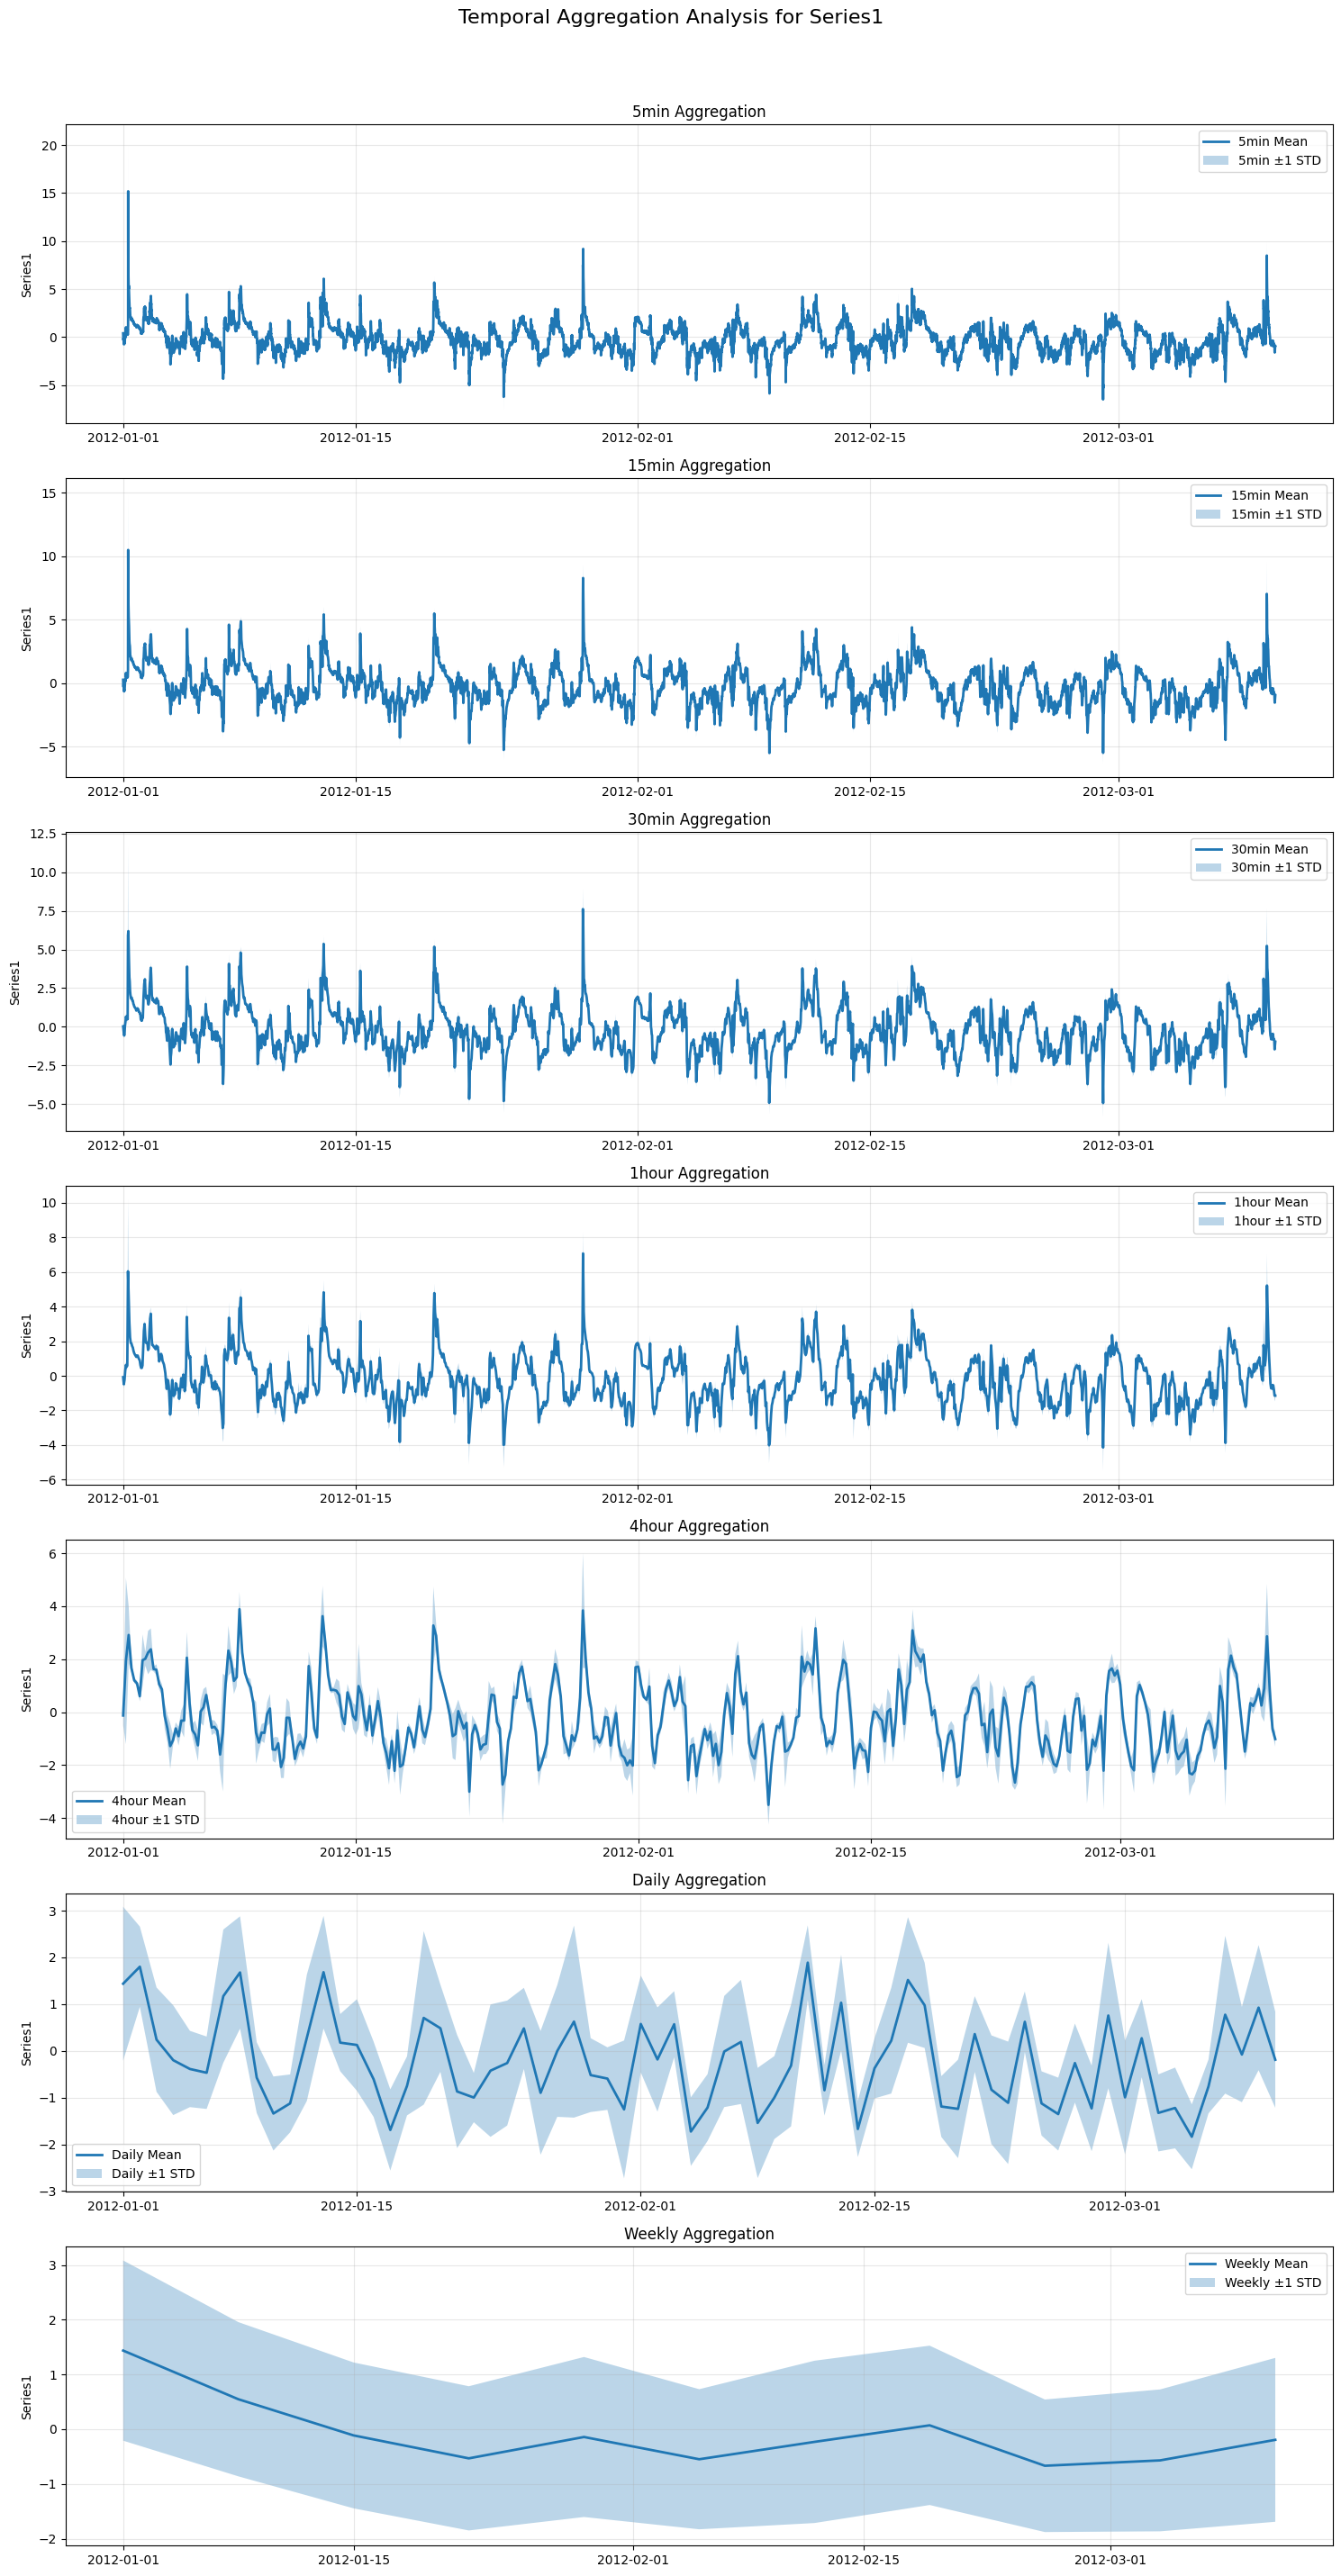

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Read the large dataset efficiently
def load_data(file_path, nrows=None):
    """Load time series data with proper datetime parsing."""
    df = pd.read_csv(file_path, parse_dates=['Date'], nrows=nrows)
    return df

# 5. Temporal Aggregation Analysis
def temporal_aggregation_analysis(df, target_col='Series1'):
    """Analyze patterns at different temporal aggregations."""
    
    # Set Date as index for easier resampling
    df_ts = df.set_index('Date')
    
    # Define aggregation levels
    aggregations = {
        '5min': '5min',
        '15min': '15min',
        '30min': '30min',
        '1hour': '1H',
        '4hour': '4H',  # Same as prediction horizon
        'Daily': 'D',
        'Weekly': 'W'
    }
    
    fig, axes = plt.subplots(len(aggregations), 1, figsize=(15, 4*len(aggregations)))
    fig.suptitle(f'Temporal Aggregation Analysis for {target_col}', fontsize=16, y=1.02)
    
    for (name, freq), ax in zip(aggregations.items(), axes):
        # Aggregate data
        agg_data = df_ts[target_col].resample(freq).agg(['mean', 'std', 'min', 'max'])
        
        # Plot mean with std band
        ax.plot(agg_data.index, agg_data['mean'], label=f'{name} Mean', linewidth=2)
        ax.fill_between(agg_data.index, 
                       agg_data['mean'] - agg_data['std'], 
                       agg_data['mean'] + agg_data['std'], 
                       alpha=0.3, label=f'{name} ±1 STD')
        
        ax.set_title(f'{name} Aggregation')
        ax.set_ylabel(target_col)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Rolling Statistics Analysis
def rolling_statistics_analysis(df, target_col='Series1', windows=[60, 240, 1440]):
    """Analyze rolling statistics with multiple window sizes."""
    
    df_ts = df.set_index('Date')
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'Rolling Statistics Analysis for {target_col}', fontsize=16, y=1.02)
    
    # Original data (sampled for visibility)
    sample_size = min(10000, len(df_ts))
    sample_idx = np.linspace(0, len(df_ts)-1, sample_size, dtype=int)
    axes[0].plot(df_ts.index[sample_idx], df_ts[target_col].iloc[sample_idx], 
                 alpha=0.5, label='Original Data (sampled)')
    
    # Rolling mean and std for different windows
    colors = ['red', 'green', 'blue']
    for window, color in zip(windows, colors):
        rolling_mean = df_ts[target_col].rolling(window=window).mean()
        rolling_std = df_ts[target_col].rolling(window=window).std()
        
        # Plot rolling mean
        axes[0].plot(df_ts.index, rolling_mean, color=color, 
                    label=f'{window}min Rolling Mean', linewidth=2)
        
        # Plot rolling std
        axes[1].plot(df_ts.index, rolling_std, color=color, 
                    label=f'{window}min Rolling STD', linewidth=2)
    
    # Rolling coefficient of variation (CV) = std/mean
    for window, color in zip(windows, colors):
        rolling_mean = df_ts[target_col].rolling(window=window).mean()
        rolling_std = df_ts[target_col].rolling(window=window).std()
        rolling_cv = rolling_std / rolling_mean
        
        axes[2].plot(df_ts.index, rolling_cv, color=color, 
                    label=f'{window}min Rolling CV', linewidth=2)
    
    axes[0].set_title('Original Data with Rolling Means')
    axes[1].set_title('Rolling Standard Deviation')
    axes[2].set_title('Rolling Coefficient of Variation (STD/Mean)')
    
    for ax in axes:
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylabel(target_col)
    
    plt.tight_layout()
    return fig

# Visualization of feature importance for 4-hour prediction
def analyze_lag_correlations(df, target_col='Series1', max_lag_hours=8):
    """Analyze correlation between current values and past lags."""
    
    df_ts = df.set_index('Date')
    
    # Create lag features
    lags_minutes = range(0, max_lag_hours * 60 + 1, 30)  # Every 30 minutes up to max_lag_hours
    lag_correlations = {}
    
    for lag in lags_minutes:
        if lag == 0:
            lag_correlations[lag] = 1.0
        else:
            lagged_values = df_ts[target_col].shift(lag)
            correlation = df_ts[target_col].corr(lagged_values)
            lag_correlations[lag] = correlation
    
    # Plot lag correlations
    fig, ax = plt.subplots(figsize=(12, 6))
    
    lags_hours = [lag/60 for lag in lags_minutes]
    correlations = list(lag_correlations.values())
    
    ax.plot(lags_hours, correlations, marker='o', linewidth=2)
    ax.axvline(x=4, color='red', linestyle='--', label='4-hour prediction horizon')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    ax.set_xlabel('Lag (hours)')
    ax.set_ylabel('Correlation')
    ax.set_title(f'Lag Correlation Analysis for {target_col}')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Highlight significant correlations
    significant_lags = [(lag/60, corr) for lag, corr in lag_correlations.items() 
                        if abs(corr) > 0.3 and lag > 0]
    
    for lag_hour, corr in significant_lags[:10]:  # Show top 10
        ax.annotate(f'{lag_hour:.1f}h: {corr:.3f}', 
                   xy=(lag_hour, corr), xytext=(5, 5), 
                   textcoords='offset points', fontsize=8)
    
    return fig, lag_correlations

# Example usage
if __name__ == "__main__":
    # Load data (you might want to load a subset first for testing)
    df = load_data('Train_timeseries.csv', nrows=100_000)  # Start with 100k rows for testing
    
    # Temporal aggregation analysis
    agg_fig = temporal_aggregation_analysis(df, target_col='Series1')
    #plt.savefig('temporal_aggregation.png', dpi=300, bbox_inches='tight')
    
    # Rolling statistics analysis
    # rolling_fig = rolling_statistics_analysis(df, target_col='Series1', # doesn't work now
    #                                         windows=[240, 1440])  # 4h, 24h, 4d
    #plt.savefig('rolling_statistics.png', dpi=300, bbox_inches='tight')
    
    # Lag correlation analysis
    #lag_fig, lag_corrs = analyze_lag_correlations(df, target_col='Series1', max_lag_hours=8)
    #plt.savefig('lag_correlations_1.png', dpi=300, bbox_inches='tight')
    
    # Show most important lags for 4-hour prediction
    # four_hour_corr = lag_corrs.get(240, None)  # 240 minutes = 4 hours
    # print(f"\n4-hour lag correlation: {four_hour_corr:.3f}")
    
    # Display all plots
    plt.show()

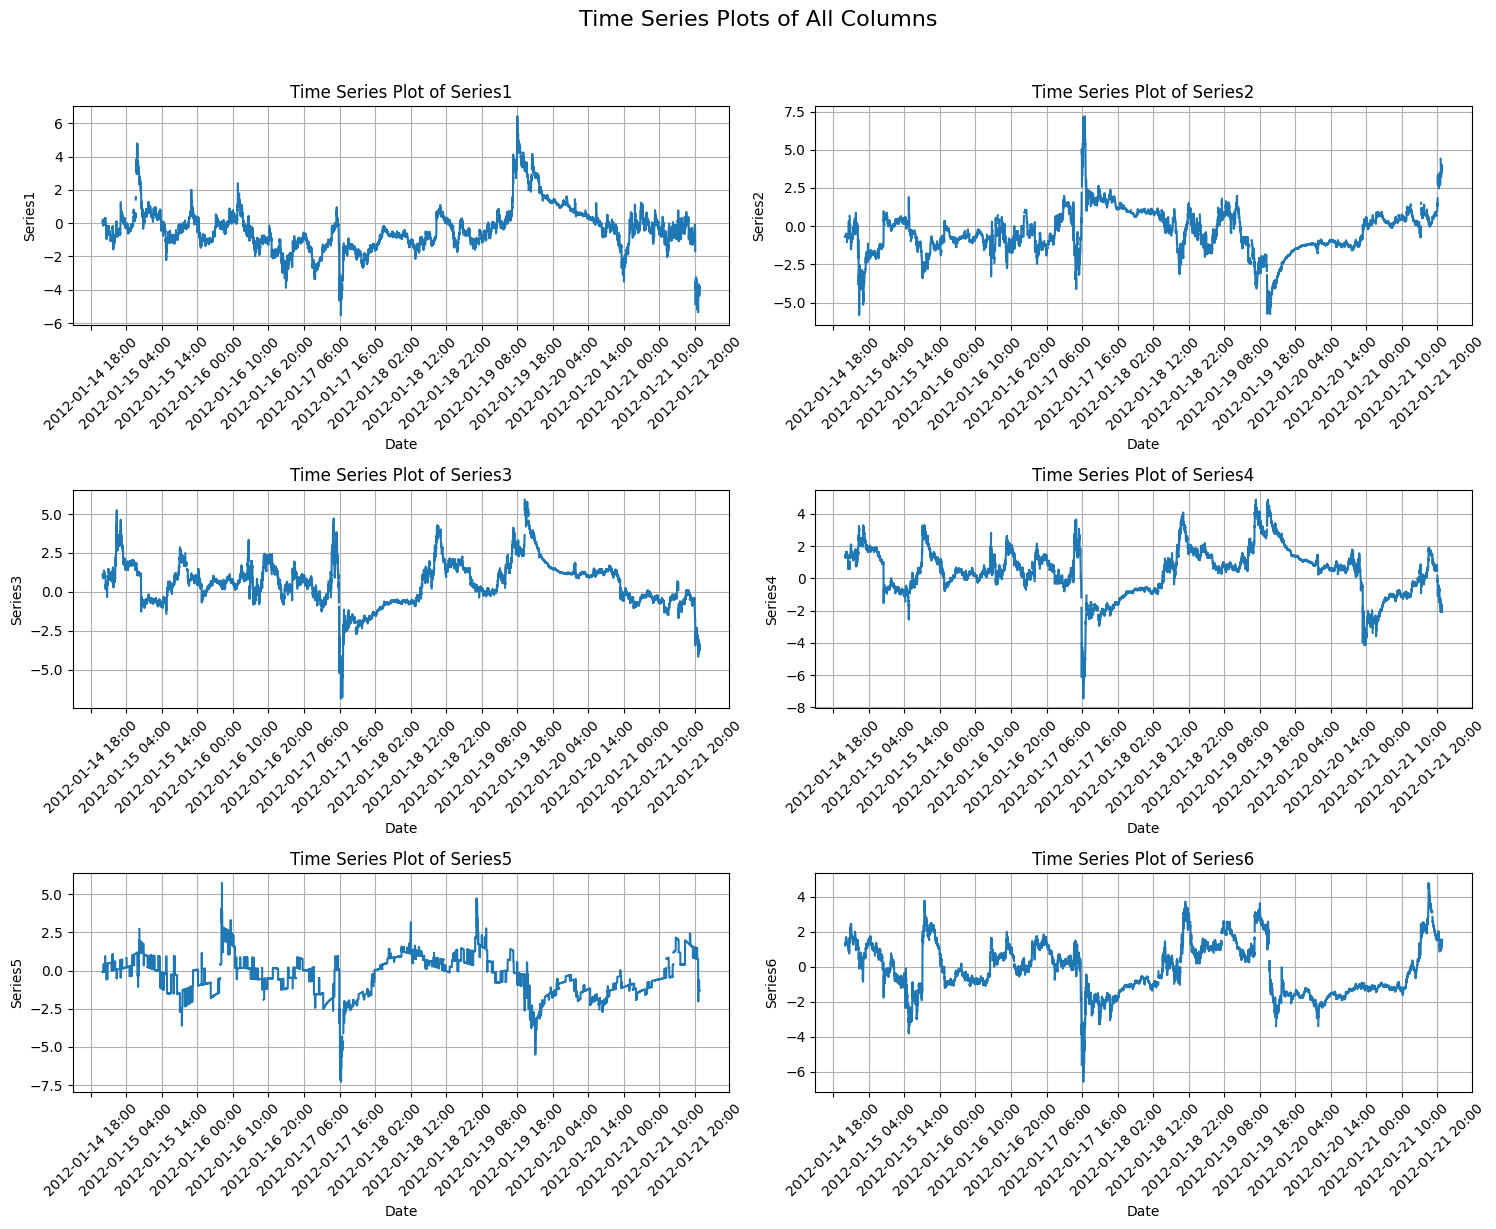

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Convert Date column to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Create a figure with 6 subplots (3 rows x 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Time Series Plots of All Columns', fontsize=16, y=1.02)

# Flatten the axes array for easier iteration
axes_flat = axes.flatten()

delta = 60*24*7
start = 20_000

# Plot each column in a separate subplot
for ind, col in enumerate(df.columns[1:]):
    ax = axes_flat[ind]
    ax.plot(df['Date'][start:start+delta], df[col][start:start+delta])
    ax.set_title(f'Time Series Plot of {col}')
    ax.set_xlabel('Date')
    ax.set_ylabel(col)
    ax.grid(True)
    
    # Customize x-axis ticks for each subplot
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=delta//1_000))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    #ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=delta//1000))
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates

def analyze_recurring_patterns(df, target_col='Series1'):
    """
    Analyze various recurring patterns in time series data.
    """
    print(f"=== PATTERN ANALYSIS FOR {target_col} ===\n")
    
    # Extract time features
    df_analysis = df.copy()
    df_analysis['hour'] = df_analysis['Date'].dt.hour
    df_analysis['minute'] = df_analysis['Date'].dt.minute
    df_analysis['day_of_week'] = df_analysis['Date'].dt.dayofweek
    df_analysis['day_name'] = df_analysis['Date'].dt.day_name()
    df_analysis['month'] = df_analysis['Date'].dt.month
    df_analysis['is_weekend'] = df_analysis['day_of_week'].isin([5, 6])
    
    # Define business hours (typically 9 AM to 5 PM)
    df_analysis['is_business_hours'] = df_analysis['hour'].between(9, 17)
    
    # Time of day categories
    df_analysis['time_of_day'] = pd.cut(df_analysis['hour'], 
                                       bins=[0, 6, 12, 18, 24], 
                                       labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                       include_lowest=True)
    
    # 1. Business Hours vs. Non-Business Hours Analysis
    business_hours_analysis(df_analysis, target_col)
    
    # 2. Weekday vs. Weekend Patterns
    weekday_weekend_analysis(df_analysis, target_col)
    
    # 3. Hourly Patterns
    hourly_patterns(df_analysis, target_col)
    
    # 4. Day of Week Patterns
    day_of_week_patterns(df_analysis, target_col)
    
    # 5. Intraday Patterns (4-hour blocks)
    intraday_patterns(df_analysis, target_col)
    
    # 6. Monthly Patterns (if data spans multiple months)
    if df_analysis['month'].nunique() > 1:
        monthly_patterns(df_analysis, target_col)
    
    return df_analysis

def business_hours_analysis(df, target_col):
    """Analyze patterns during business hours vs. non-business hours."""
    
    # Statistics comparison
    business_stats = df.groupby('is_business_hours')[target_col].agg(['mean', 'std', 'min', 'max', 'count'])
    print("\n1. Business Hours vs. Non-Business Hours Statistics:")
    print(business_stats)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Box plot comparison
    sns.boxplot(data=df, x='is_business_hours', y=target_col, ax=axes[0, 0])
    axes[0, 0].set_title('Value Distribution: Business vs. Non-Business Hours')
    axes[0, 0].set_xticklabels(['Non-Business Hours', 'Business Hours'])
    
    # Violin plot for distribution shape
    sns.violinplot(data=df, x='is_business_hours', y=target_col, ax=axes[0, 1])
    axes[0, 1].set_title('Distribution Shape: Business vs. Non-Business Hours')
    axes[0, 1].set_xticklabels(['Non-Business Hours', 'Business Hours'])
    
    # Average hourly values
    hourly_avg = df.groupby(['hour', 'is_business_hours'])[target_col].mean().reset_index()
    business_hours = hourly_avg[hourly_avg['is_business_hours']]
    non_business_hours = hourly_avg[~hourly_avg['is_business_hours']]
    
    axes[1, 0].plot(business_hours['hour'], business_hours[target_col], 
                    marker='o', label='Business Hours', linewidth=2)
    axes[1, 0].plot(non_business_hours['hour'], non_business_hours[target_col], 
                    marker='o', label='Non-Business Hours', linewidth=2)
    axes[1, 0].set_xlabel('Hour of Day')
    axes[1, 0].set_ylabel(f'Average {target_col}')
    axes[1, 0].set_title('Hourly Averages: Business vs. Non-Business Hours')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Time of day distribution
    time_of_day_avg = df.groupby(['time_of_day', 'is_business_hours'])[target_col].mean().reset_index()
    time_of_day_pivot = time_of_day_avg.pivot(index='time_of_day', columns='is_business_hours', values=target_col)
    time_of_day_pivot.plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Average Values by Time of Day')
    axes[1, 1].set_xlabel('Time of Day')
    axes[1, 1].set_ylabel(f'Average {target_col}')
    axes[1, 1].legend(['Non-Business Hours', 'Business Hours'])
    
    plt.tight_layout()
    plt.savefig('business_hours_analysis_'+target_col+'.png', dpi=300, bbox_inches='tight')
    plt.close()

def weekday_weekend_analysis(df, target_col):
    """Analyze weekday vs. weekend patterns."""
    
    # Statistics comparison
    weekend_stats = df.groupby('is_weekend')[target_col].agg(['mean', 'std', 'min', 'max', 'count'])
    print("\n2. Weekday vs. Weekend Statistics:")
    print(weekend_stats)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Box plot comparison
    sns.boxplot(data=df, x='is_weekend', y=target_col, ax=axes[0, 0])
    axes[0, 0].set_title('Value Distribution: Weekday vs. Weekend')
    axes[0, 0].set_xticklabels(['Weekday', 'Weekend'])
    
    # Hourly patterns by weekday/weekend
    hourly_weekend = df.groupby(['hour', 'is_weekend'])[target_col].mean().reset_index()
    weekday_hours = hourly_weekend[~hourly_weekend['is_weekend']]
    weekend_hours = hourly_weekend[hourly_weekend['is_weekend']]
    
    axes[0, 1].plot(weekday_hours['hour'], weekday_hours[target_col], 
                    marker='o', label='Weekday', linewidth=2)
    axes[0, 1].plot(weekend_hours['hour'], weekend_hours[target_col], 
                    marker='o', label='Weekend', linewidth=2)
    axes[0, 1].set_xlabel('Hour of Day')
    axes[0, 1].set_ylabel(f'Average {target_col}')
    axes[0, 1].set_title('Hourly Patterns: Weekday vs. Weekend')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Day of week detailed view
    day_avg = df.groupby('day_name')[target_col].mean().reindex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    day_avg.plot(kind='bar', ax=axes[1, 0], color=['skyblue']*5 + ['lightcoral']*2)
    axes[1, 0].set_title('Average Values by Day of Week')
    axes[1, 0].set_ylabel(f'Average {target_col}')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Heatmap of hour vs day of week
    pivot_data = df.pivot_table(values=target_col, index='hour', columns='day_name', 
                                aggfunc='mean')[['Monday', 'Tuesday', 'Wednesday', 
                                                 'Thursday', 'Friday', 'Saturday', 'Sunday']]
    sns.heatmap(pivot_data, cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': f'Average {target_col}'})
    axes[1, 1].set_title('Hour vs Day of Week Heatmap')
    axes[1, 1].set_ylabel('Hour of Day')
    
    plt.tight_layout()
    plt.savefig('weekday_weekend_analysis_' + target_col + '.png', dpi=300, bbox_inches='tight')
    plt.close()

def hourly_patterns(df, target_col):
    """Analyze hourly patterns in detail."""
    
    # Hourly statistics
    hourly_stats = df.groupby('hour')[target_col].agg(['mean', 'std', 'min', 'max', 'count'])
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Average values by hour
    axes[0, 0].plot(hourly_stats.index, hourly_stats['mean'], marker='o', linewidth=2)
    axes[0, 0].fill_between(hourly_stats.index, 
                           hourly_stats['mean'] - hourly_stats['std'],
                           hourly_stats['mean'] + hourly_stats['std'],
                           alpha=0.3, label='±1 STD')
    axes[0, 0].set_xlabel('Hour of Day')
    axes[0, 0].set_ylabel(f'Average {target_col}')
    axes[0, 0].set_title('Hourly Average with Standard Deviation')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Box plot by hour
    df_sample = df.sample(min(100000, len(df)))  # Sample for visualization
    sns.boxplot(data=df_sample, x='hour', y=target_col, ax=axes[0, 1])
    axes[0, 1].set_title('Value Distribution by Hour')
    
    # Hourly standard deviation
    axes[1, 0].bar(hourly_stats.index, hourly_stats['std'], alpha=0.7)
    axes[1, 0].set_xlabel('Hour of Day')
    axes[1, 0].set_ylabel('Standard Deviation')
    axes[1, 0].set_title('Volatility by Hour')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Minute-level patterns within hours
    minute_hour_avg = df.groupby(['hour', 'minute'])[target_col].mean().reset_index()
    pivot_minute = minute_hour_avg.pivot(index='minute', columns='hour', values=target_col)
    
    # Show patterns for selected hours
    selected_hours = [0, 6, 12, 18]  # Midnight, morning, noon, evening
    for hour in selected_hours:
        if hour in pivot_minute.columns:
            axes[1, 1].plot(pivot_minute.index, pivot_minute[hour], 
                           label=f'Hour {hour:02d}', alpha=0.7)
    
    axes[1, 1].set_xlabel('Minute')
    axes[1, 1].set_ylabel(f'Average {target_col}')
    axes[1, 1].set_title('Minute-Level Patterns for Selected Hours')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('hourly_patterns_'+target_col+'.png', dpi=300, bbox_inches='tight')
    plt.close()

def day_of_week_patterns(df, target_col):
    """Analyze patterns by day of week."""
    
    # Day of week statistics
    day_stats = df.groupby(['day_of_week', 'day_name'])[target_col].agg(['mean', 'std', 'count'])
    day_stats = day_stats.reset_index().sort_values('day_of_week')
    
    # Visualization
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # Daily averages with error bars
    axes[0].bar(day_stats['day_name'], day_stats['mean'], 
                yerr=day_stats['std'], capsize=5, alpha=0.7,
                color=['skyblue']*5 + ['lightcoral']*2)
    axes[0].set_ylabel(f'Average {target_col}')
    axes[0].set_title('Average Values by Day of Week with Standard Deviation')
    axes[0].grid(True, alpha=0.3)
    
    # Hourly patterns for each day
    hourly_day = df.groupby(['day_name', 'hour'])[target_col].mean().reset_index()
    
    for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
        day_data = hourly_day[hourly_day['day_name'] == day]
        style = '-' if day not in ['Saturday', 'Sunday'] else '--'
        axes[1].plot(day_data['hour'], day_data[target_col], style, 
                    label=day, alpha=0.7, linewidth=2)
    
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel(f'Average {target_col}')
    axes[1].set_title('Hourly Patterns by Day of Week')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('day_of_week_patterns_'+target_col+'.png', dpi=300, bbox_inches='tight')
    plt.close()

def intraday_patterns(df, target_col):
    """Analyze intraday patterns in 4-hour blocks."""
    
    # Create 4-hour blocks
    df['hour_block'] = pd.cut(df['hour'], 
                             bins=[0, 4, 8, 12, 16, 20, 24],
                             labels=['00-04', '04-08', '08-12', '12-16', '16-20', '20-24'],
                             include_lowest=True)
    
    # Statistics by block
    block_stats = df.groupby('hour_block')[target_col].agg(['mean', 'std', 'count'])
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Average values by block
    block_stats['mean'].plot(kind='bar', ax=axes[0, 0], alpha=0.7)
    axes[0, 0].set_ylabel(f'Average {target_col}')
    axes[0, 0].set_title('Average Values by 4-Hour Blocks')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Volatility by block
    block_stats['std'].plot(kind='bar', ax=axes[0, 1], alpha=0.7, color='orange')
    axes[0, 1].set_ylabel('Standard Deviation')
    axes[0, 1].set_title('Volatility by 4-Hour Blocks')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Distribution by block
    df_sample = df.sample(min(100000, len(df)))
    sns.violinplot(data=df_sample, x='hour_block', y=target_col, ax=axes[1, 0])
    axes[1, 0].set_title('Value Distribution by 4-Hour Blocks')
    
    # Heatmap of minute within block
    minute_block_avg = df.groupby(['hour_block', 'minute'])[target_col].mean().reset_index()
    pivot_block = minute_block_avg.pivot(index='minute', columns='hour_block', values=target_col)
    sns.heatmap(pivot_block, cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': f'Average {target_col}'})
    axes[1, 1].set_title('Minute-Level Patterns within 4-Hour Blocks')
    axes[1, 1].set_ylabel('Minute')
    
    plt.tight_layout()
    plt.savefig('intraday_patterns_'+target_col+'.png', dpi=300, bbox_inches='tight')
    plt.close()

def monthly_patterns(df, target_col):
    """Analyze monthly patterns if data spans multiple months."""
    
    # Monthly statistics
    monthly_stats = df.groupby('month')[target_col].agg(['mean', 'std', 'count'])
    
    # Visualization
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Monthly averages
    monthly_stats['mean'].plot(kind='bar', ax=axes[0], alpha=0.7)
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel(f'Average {target_col}')
    axes[0].set_title('Monthly Average Values')
    axes[0].grid(True, alpha=0.3)
    
    # Day of month patterns
    df['day_of_month'] = df['Date'].dt.day
    day_of_month_avg = df.groupby('day_of_month')[target_col].mean()
    
    axes[1].plot(day_of_month_avg.index, day_of_month_avg.values, marker='o', linewidth=2)
    axes[1].set_xlabel('Day of Month')
    axes[1].set_ylabel(f'Average {target_col}')
    axes[1].set_title('Day of Month Patterns')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('monthly_patterns_' + target_col + '.png', dpi=300, bbox_inches='tight')
    plt.close()

# Example usage
if __name__ == "__main__":
    # Load data
    df = pd.read_csv('Train_timeseries.csv', parse_dates=['Date'])
    
    # Analyze patterns for each series
    for series_col in [col for col in df.columns if col.startswith('Series')]:
        print(f"\nAnalyzing patterns for {series_col}...")
        analyze_recurring_patterns(df, series_col)


Analyzing patterns for Series1...
=== PATTERN ANALYSIS FOR Series1 ===


1. Business Hours vs. Non-Business Hours Statistics:
                       mean       std        min        max   count
is_business_hours                                                  
False             -0.081155  1.441368 -10.886144  24.358037  557598
True              -0.090297  1.435919  -7.811971  10.923186  334685


/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Non-Business Hours', 'Business Hours'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Non-Business Hours', 'Business Hours'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_of_day_avg = df.groupby(['time_of_day', 'is_business_hours'])[target_col].mean().reset_index()



2. Weekday vs. Weekend Statistics:
                mean       std        min        max   count
is_weekend                                                  
False      -0.103073  1.428181 -10.886144  13.043147  636757
True       -0.038511  1.465740  -8.270853  24.358037  255526


/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Weekday', 'Weekend'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:254: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  block_stats = df.groupby('hour_block')[target_col].agg(['mean', 'std', 'count'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minute_blo


Analyzing patterns for Series2...
=== PATTERN ANALYSIS FOR Series2 ===


1. Business Hours vs. Non-Business Hours Statistics:
                       mean       std        min        max   count
is_business_hours                                                  
False             -0.052795  1.442690 -12.837726  13.848687  557853
True              -0.041943  1.473014 -10.502383  15.891363  334986


/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Non-Business Hours', 'Business Hours'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Non-Business Hours', 'Business Hours'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_of_day_avg = df.groupby(['time_of_day', 'is_business_hours'])[target_col].mean().reset_index()



2. Weekday vs. Weekend Statistics:
                mean       std        min        max   count
is_weekend                                                  
False      -0.057973  1.447081 -12.837726  15.891363  637033
True       -0.025690  1.471357 -10.502383  13.848687  255806


/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Weekday', 'Weekend'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:254: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  block_stats = df.groupby('hour_block')[target_col].agg(['mean', 'std', 'count'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minute_blo


Analyzing patterns for Series3...
=== PATTERN ANALYSIS FOR Series3 ===


1. Business Hours vs. Non-Business Hours Statistics:
                       mean       std        min        max   count
is_business_hours                                                  
False              0.090723  1.462384 -13.212723  13.418575  557558
True               0.083241  1.489897 -15.252152  12.197933  334876


/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Non-Business Hours', 'Business Hours'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Non-Business Hours', 'Business Hours'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_of_day_avg = df.groupby(['time_of_day', 'is_business_hours'])[target_col].mean().reset_index()



2. Weekday vs. Weekend Statistics:
                mean       std        min        max   count
is_weekend                                                  
False       0.103052  1.462708 -15.252152  13.418575  636783
True        0.050213  1.496884 -13.212723  12.197933  255651


/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Weekday', 'Weekend'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:254: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  block_stats = df.groupby('hour_block')[target_col].agg(['mean', 'std', 'count'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minute_blo


Analyzing patterns for Series4...
=== PATTERN ANALYSIS FOR Series4 ===


1. Business Hours vs. Non-Business Hours Statistics:
                       mean       std        min        max   count
is_business_hours                                                  
False              0.027985  1.460927 -13.428796  13.147020  557823
True               0.047944  1.476901 -15.302137  10.844058  334682


/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Non-Business Hours', 'Business Hours'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Non-Business Hours', 'Business Hours'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_of_day_avg = df.groupby(['time_of_day', 'is_business_hours'])[target_col].mean().reset_index()



2. Weekday vs. Weekend Statistics:
                mean       std        min        max   count
is_weekend                                                  
False       0.038897  1.455520 -15.302137  13.147020  636909
True        0.026927  1.495086 -13.428796  10.844058  255596


/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Weekday', 'Weekend'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:254: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  block_stats = df.groupby('hour_block')[target_col].agg(['mean', 'std', 'count'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minute_blo


Analyzing patterns for Series5...
=== PATTERN ANALYSIS FOR Series5 ===


1. Business Hours vs. Non-Business Hours Statistics:
                       mean      std        min        max   count
is_business_hours                                                 
False             -0.078085  1.40366 -37.920965  18.314306  558214
True              -0.040320  1.40135  -7.285424  10.373052  334628


/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Non-Business Hours', 'Business Hours'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Non-Business Hours', 'Business Hours'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_of_day_avg = df.groupby(['time_of_day', 'is_business_hours'])[target_col].mean().reset_index()



2. Weekday vs. Weekend Statistics:
                mean       std        min        max   count
is_weekend                                                  
False       0.006204  1.413618 -37.920965  18.314306  637179
True       -0.238725  1.360226  -6.454173  12.681980  255663


/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Weekday', 'Weekend'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:254: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  block_stats = df.groupby('hour_block')[target_col].agg(['mean', 'std', 'count'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minute_blo


Analyzing patterns for Series6...
=== PATTERN ANALYSIS FOR Series6 ===


1. Business Hours vs. Non-Business Hours Statistics:
                      mean       std       min        max   count
is_business_hours                                                
False             -0.18317  1.445242 -9.585980  12.423665  558037
True              -0.19196  1.456549 -8.918306  10.394145  334722


/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Non-Business Hours', 'Business Hours'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Non-Business Hours', 'Business Hours'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_of_day_avg = df.groupby(['time_of_day', 'is_business_hours'])[target_col].mean().reset_index()



2. Weekday vs. Weekend Statistics:
                mean       std       min        max   count
is_weekend                                                 
False      -0.189297  1.437427 -9.585980  12.423665  637136
True       -0.179408  1.479133 -9.359166  10.446552  255623


/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Weekday', 'Weekend'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:254: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  block_stats = df.groupby('hour_block')[target_col].agg(['mean', 'std', 'count'])
/var/folders/zy/3lv6prfd5ws7qj_nglpssbxm0000gn/T/ipykernel_20443/1411707651.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minute_blo

: 

AUTOCORRELATION

In [ ]:
import cupy as cp
import numpy as np

def gpu_autocorrelation(series, nlags=800):
    # Move data to GPU
    gpu_series = cp.array(series)
    n = len(gpu_series)

    # Compute FFT
    fft = cp.fft.fft(gpu_series, n=2*n)

    # Compute power spectrum
    power_spectrum = cp.abs(fft)**2

    # Inverse FFT to get autocorrelation
    acf = cp.fft.ifft(power_spectrum)[:n].real
    acf = acf / acf[0]  # Normalize

    return cp.asnumpy(acf[:nlags+1])

# Process all series in parallel
gpu_acf_results = {}
for col in df.columns[1:]:
    gpu_acf_results[col] = gpu_autocorrelation(df[col].dropna().values)

In [ ]:
gpu_acf_results

STL

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
import cupy as cp  # GPU-accelerated NumPy
from numba import cuda
import cuml  # GPU-accelerated machine learning
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesAnalyzer:
    def __init__(self, data, use_gpu=True):
        """
        Initialize the analyzer with your dataset
        data: pandas DataFrame with Date column and 6 series columns
        use_gpu: whether to use GPU acceleration
        """
        self.data = data
        self.use_gpu = use_gpu and cp.cuda.is_available()

        if self.use_gpu:
            print("GPU acceleration enabled!")
            # Transfer data to GPU
            self.gpu_data = {col: cp.array(data[col].values)
                            for col in data.columns if col != 'Date'}
        else:
            print("GPU not available, using CPU")
            self.gpu_data = None

    def detect_seasonality(self, column, seasonal_period=52, plot=True):
        """
        Detect seasonality using FFT and STL decomposition
        freq: 'H' for hourly, 'D' for daily, 'W' for weekly
        """
        print(f"\n=== Seasonality Detection for {column} ===")

        # Handle missing values
        series = self.data[column].dropna()

        # 1. Fast Fourier Transform (FFT) for frequency analysis
        if self.use_gpu:
            # GPU accelerated FFT
            fft_values = cp.fft.fft(cp.array(series.values))
            frequencies = cp.fft.fftfreq(len(series))
            power_spectrum = cp.abs(fft_values) ** 2

            # Transfer back to CPU for plotting
            frequencies = cp.asnumpy(frequencies)
            power_spectrum = cp.asnumpy(power_spectrum)
        else:
            fft_values = np.fft.fft(series.values)
            frequencies = np.fft.fftfreq(len(series))
            power_spectrum = np.abs(fft_values) ** 2

        # Find dominant frequencies
        threshold = np.mean(power_spectrum) + 2 * np.std(power_spectrum)
        dominant_frequencies = frequencies[power_spectrum > threshold]
        dominant_periods = 1 / np.abs(dominant_frequencies[dominant_frequencies != 0])

        print(f"Dominant periods found: {dominant_periods[:5]} (in number of samples)")


        try:
            stl = STL(series, period=seasonal_period, robust=True)
            result = stl.fit()

            if plot:
                fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))
                result.observed.plot(ax=ax1)
                ax1.set_ylabel('Observed')
                result.trend.plot(ax=ax2)
                ax2.set_ylabel('Trend')
                result.seasonal.plot(ax=ax3)
                ax3.set_ylabel('Seasonal')
                result.resid.plot(ax=ax4)
                ax4.set_ylabel('Residual')
                plt.suptitle(f'STL Decomposition - {column}')
                plt.tight_layout()
                plt.show()
        except:
            print("STL decomposition failed - insufficient data or too many missing values")

        return dominant_periods if len(dominant_periods) > 0 else None

    def detect_regimes(self, column, num_regimes=2, plot=True):
        """
        Detect different regimes in the data using Hidden Markov Models
        num_regimes: number of different states/regimes to detect
        """
        print(f"\n=== Regime Detection for {column} ===")

        series = self.data[column].dropna()

        # Prepare data for regime detection
        returns = series.pct_change().dropna()

        if self.use_gpu:
            # Use GPU-accelerated implementation
            from cuml.cluster import KMeans  # GPU-accelerated clustering

            # Prepare features: returns and rolling volatility
            features_gpu = cp.column_stack([
                cp.array(returns.values),
                cp.array(returns.rolling(20).std().values)
            ])
            features_gpu = features_gpu[~cp.isnan(features_gpu).any(axis=1)]

            # Fit KMeans on GPU
            kmeans = KMeans(n_clusters=num_regimes)
            labels = kmeans.fit_predict(features_gpu)

            # Transfer back to CPU
            labels = cp.asnumpy(labels)
        else:
            from sklearn.cluster import KMeans

            features = np.column_stack([
                returns.values,
                returns.rolling(20).std().values
            ])
            features = features[~np.isnan(features).any(axis=1)]

            kmeans = KMeans(n_clusters=num_regimes)
            labels = kmeans.fit_predict(features)

        # Create regime indicator
        regime_indicator = pd.Series(labels, index=returns.index[19:])

        if plot:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            series.plot(ax=ax1)
            ax1.set_title(f'Original Series - {column}')
            ax1.set_ylabel('Value')

            for regime in range(num_regimes):
                mask = regime_indicator == regime
                ax2.scatter(regime_indicator[mask].index, series.loc[regime_indicator[mask].index],
                          label=f'Regime {regime}', alpha=0.6)
            ax2.set_title('Detected Regimes')
            ax2.set_ylabel('Value')
            ax2.legend()
            plt.tight_layout()
            plt.show()

        # Calculate regime statistics
        for regime in range(num_regimes):
            mask = regime_indicator == regime
            regime_data = series.loc[regime_indicator[mask].index]
            print(f"Regime {regime} statistics:")
            print(f"  Mean: {regime_data.mean():.3f}")
            print(f"  Std:  {regime_data.std():.3f}")
            print(f"  Duration: {mask.sum()} samples")

        return regime_indicator

    def spectrum_analysis(self, column, plot=True):
        """
        Perform spectrum analysis to understand frequency components
        """
        print(f"\n=== Spectrum Analysis for {column} ===")

        series = self.data[column].dropna()

        if self.use_gpu:
            # GPU-accelerated spectral analysis
            signal_gpu = cp.array(series.values)

            # Compute periodogram
            freqs_gpu, power_gpu = self._gpu_periodogram(signal_gpu)

            # Transfer back to CPU for plotting
            freqs = cp.asnumpy(freqs_gpu)
            power = cp.asnumpy(power_gpu)
        else:
            # CPU implementation
            freqs, power = signal.periodogram(series.values,
                                           fs=1.0,  # Sampling frequency
                                           scaling='spectrum')

        # Find peaks in the spectrum
        peaks, _ = signal.find_peaks(power, height=np.percentile(power, 90))

        if plot:
            plt.figure(figsize=(12, 6))
            plt.semilogy(freqs, power)
            plt.plot(freqs[peaks], power[peaks], 'ro')
            plt.xlabel('Frequency')
            plt.ylabel('Power Spectrum')
            plt.title(f'Power Spectrum - {column}')
            plt.grid(True)

            # Annotate dominant frequencies
            for peak in peaks[:5]:  # Top 5 peaks
                plt.annotate(f'Period: {1/freqs[peak]:.1f}',
                           xy=(freqs[peak], power[peak]),
                           xytext=(10, 10), textcoords='offset points')
            plt.show()

        # Convert frequencies to periods
        dominant_frequencies = freqs[peaks]
        dominant_periods = 1 / dominant_frequencies[dominant_frequencies > 0]

        print(f"Dominant periods: {dominant_periods[:5]} samples")

        return freqs, power, dominant_periods

    def _gpu_periodogram(self, signal_gpu):
        """GPU implementation of periodogram"""
        n = len(signal_gpu)
        fft_result = cp.fft.fft(signal_gpu)
        power = cp.abs(fft_result) ** 2 / n
        freqs = cp.fft.fftfreq(n)

        # Return only positive frequencies
        positive_freqs = freqs[:n//2]
        positive_power = power[:n//2]

        return positive_freqs, positive_power

    def analyze_all_series(self, seasonal_period = 52, num_regimes = 2):
        """Run all analyses on all series"""
        series_columns = [col for col in self.data.columns if col != 'Date']

        results = {}
        for column in series_columns:
            print(f"\n{'='*20} Analyzing {column} {'='*20}")

            # Seasonality detection
            seasonality = self.detect_seasonality(column, seasonal_period = seasonal_period)

            # Regime detection
            #regimes = self.detect_regimes(column, num_regimes = num_regimes)

            # Spectrum analysis
            freqs, power, periods = self.spectrum_analysis(column)

            results[column] = {
                'seasonality': seasonality,
                #'regimes': regimes,
                'spectrum': (freqs, power, periods)
            }

        return results

# Example usage:

# GPU-accelerated cross-correlation analysis
@cuda.jit
def gpu_cross_correlation(x, y, result):
    """GPU kernel for cross-correlation"""
    idx = cuda.grid(1)
    if idx < len(result):
        sum_val = 0.0
        for i in range(len(x) - idx):
            sum_val += x[i] * y[i + idx]
        result[idx] = sum_val / (len(x) - idx)

sample_data = df.dropna()[:100_000]

analyzer = TimeSeriesAnalyzer(sample_data, use_gpu=True)

# 4. Run analysis on all series
print("\nRunning complete analysis on all series...")
results = analyzer.analyze_all_series(seasonal_period=24*60*4)

# 5. Advanced analyses
print("\n=== Advanced Analyses ===")


# 6. Visualize results summary
def plot_analysis_summary(data, results):
    """Create a comprehensive summary plot"""
    fig = plt.figure(figsize=(15, 10))

    # Plot original series
    ax1 = plt.subplot(2, 2, 1)
    for col in data.columns:
        ax1.plot(data.index, data[col], label=col, alpha=0.7)
    ax1.set_title('Original Time Series')
    ax1.legend()

    # Plot detected seasonalities
    ax2 = plt.subplot(2, 2, 2)
    for i, col in enumerate(data.columns):
        if results[col]['seasonality'] is not None:
            periods = results[col]['seasonality']
            if len(periods) > 0:
                ax2.bar(i, periods[0], label=col)
    ax2.set_title('Dominant Seasonal Periods')
    ax2.set_xlabel('Series')
    ax2.set_ylabel('Period (samples)')
    ax2.set_xticks(range(len(data.columns)))
    ax2.set_xticklabels(data.columns, rotation=45)

    # Plot regime changes for one series
    # ax3 = plt.subplot(2, 2, 3)
    # example_series = 'Series5'
    # regimes = results[example_series]['regimes']
    # ax3.plot(data.index, data[example_series], alpha=0.5)
    # for regime in regimes.unique():
    #     mask = regimes == regime
    #     ax3.scatter(regimes[mask].index, data[example_series].loc[regimes[mask].index],
    #                label=f'Regime {regime}', alpha=0.7)
    # ax3.set_title(f'Regime Detection - {example_series}')
    # ax3.legend()

    # Plot power spectrum for one series
    ax4 = plt.subplot(2, 2, 4)
    example_series = 'Series2'
    freqs, power, _ = results[example_series]['spectrum']
    ax4.semilogy(freqs, power)
    ax4.set_title(f'Power Spectrum - {example_series}')
    ax4.set_xlabel('Frequency')
    ax4.set_ylabel('Power')

    plt.tight_layout()
    plt.show()

# Create summary visualization
plot_analysis_summary(sample_data, results)

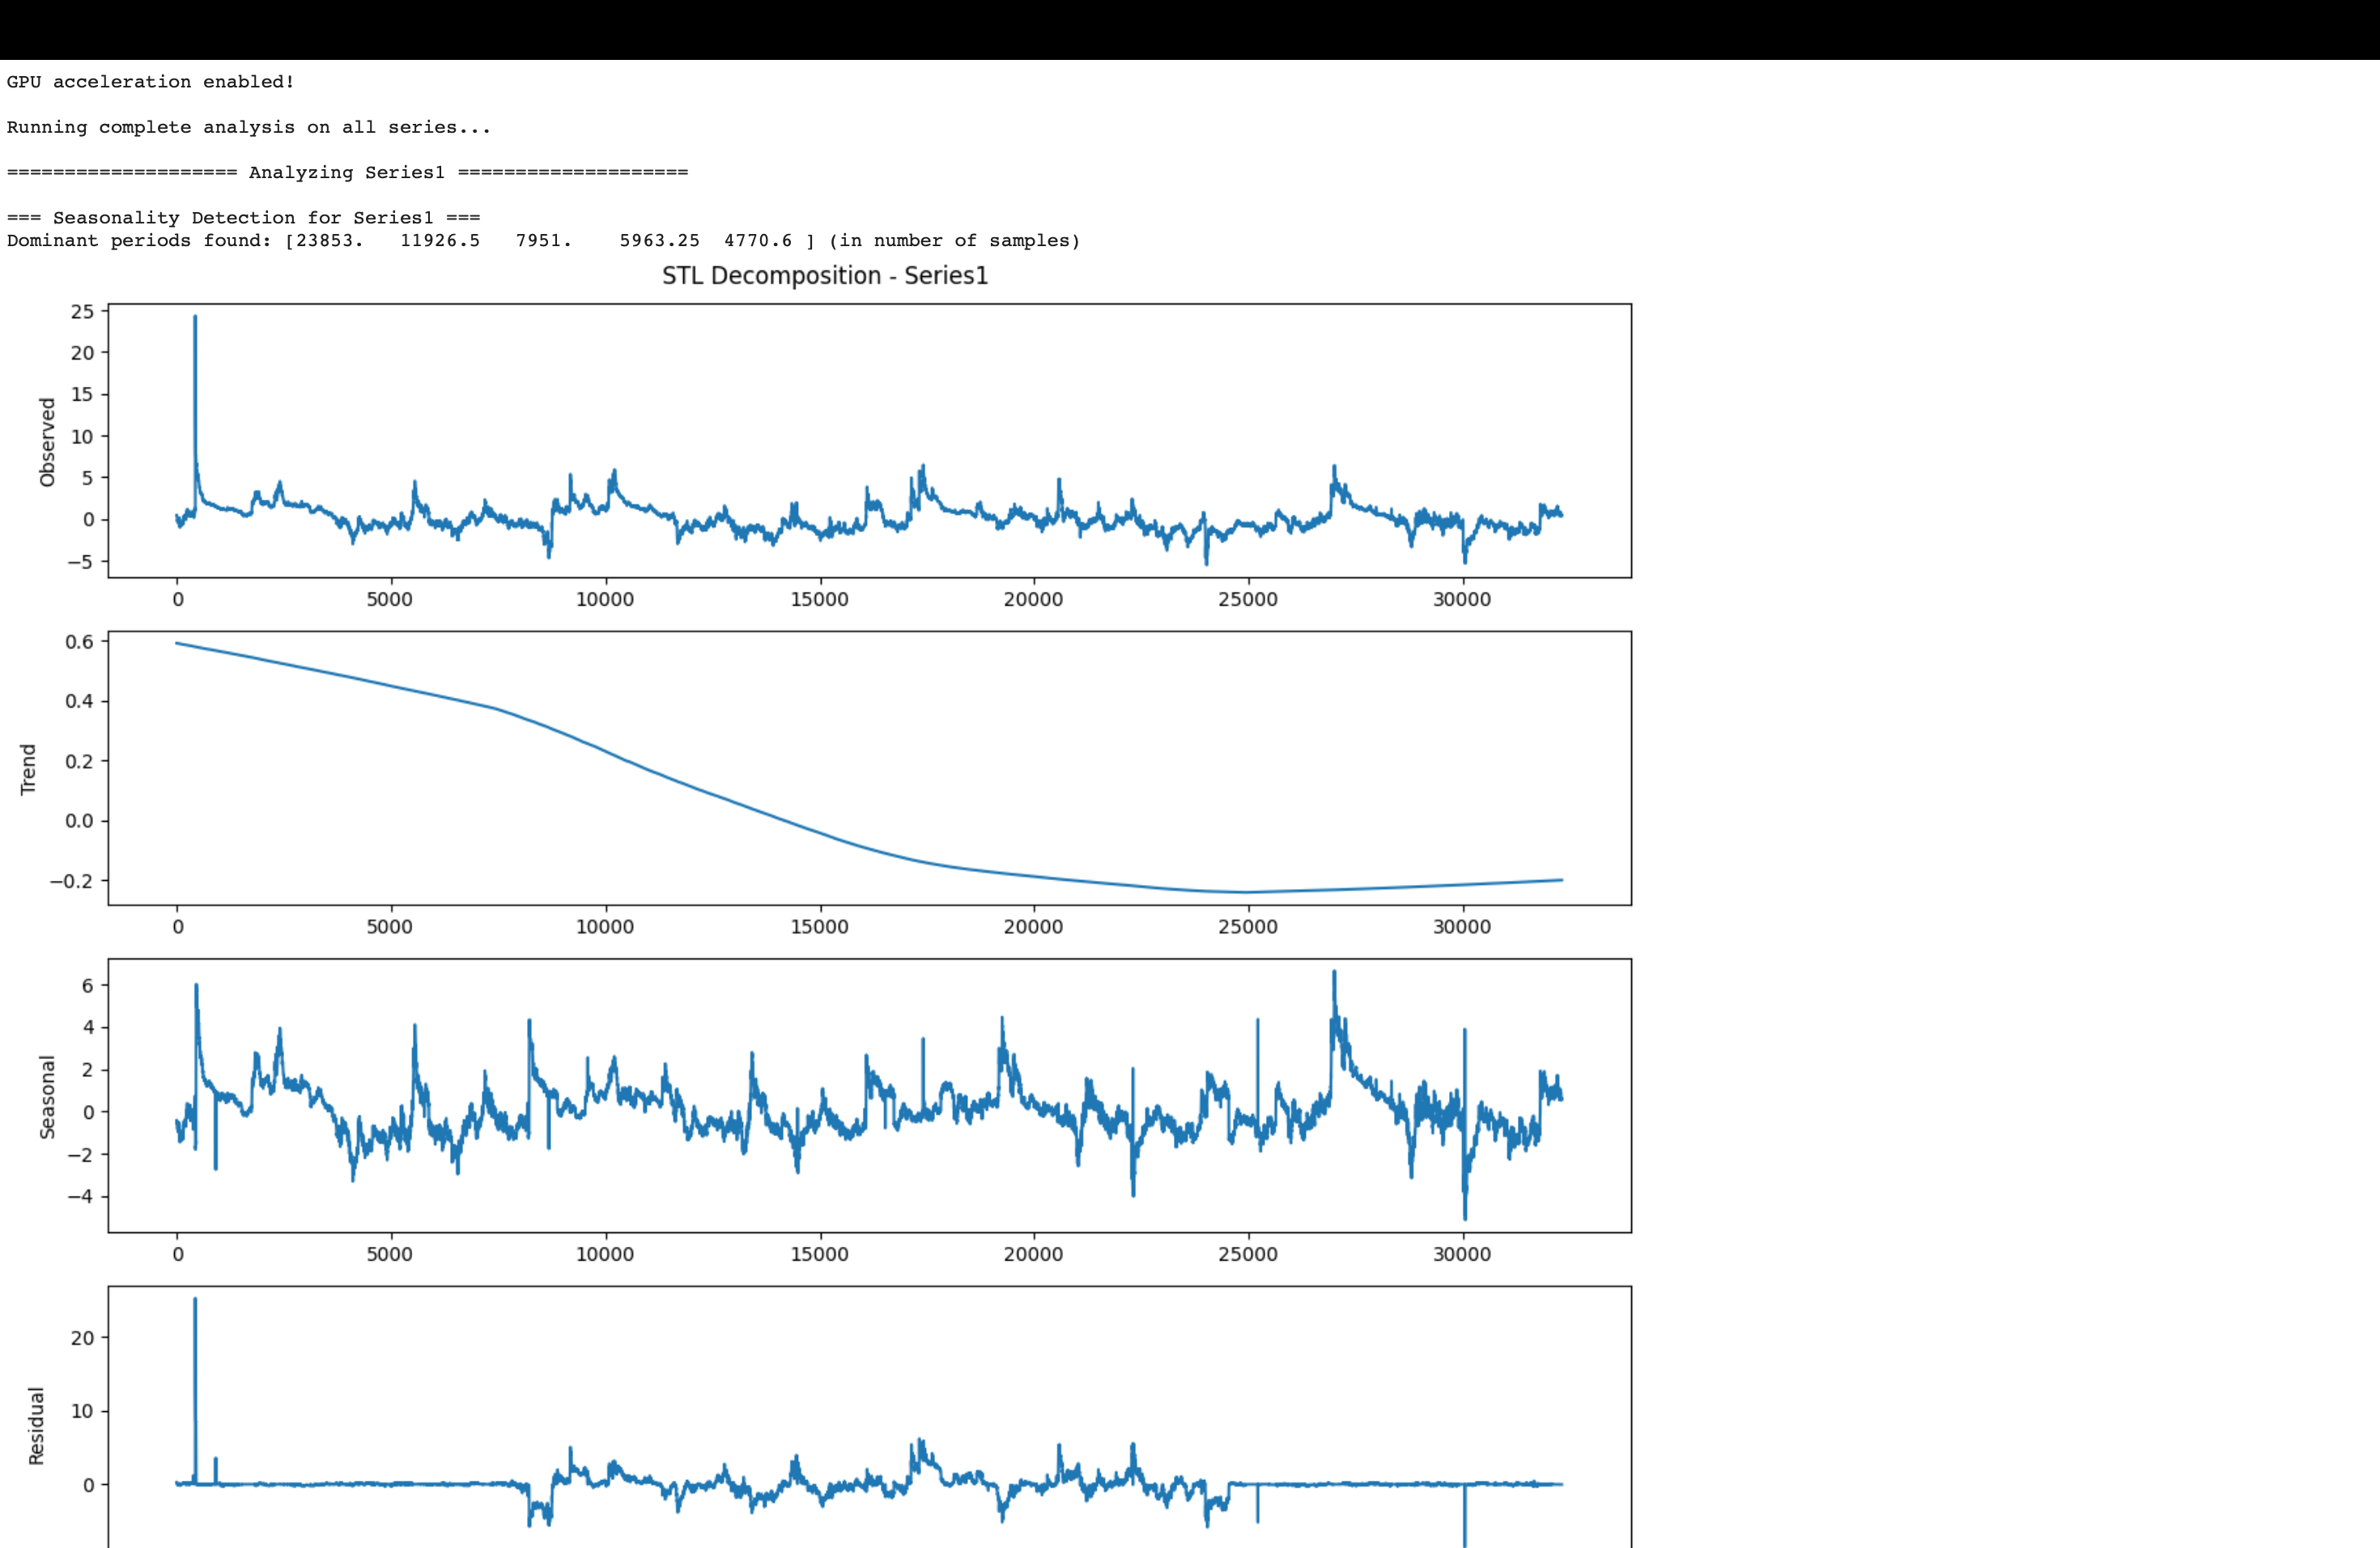

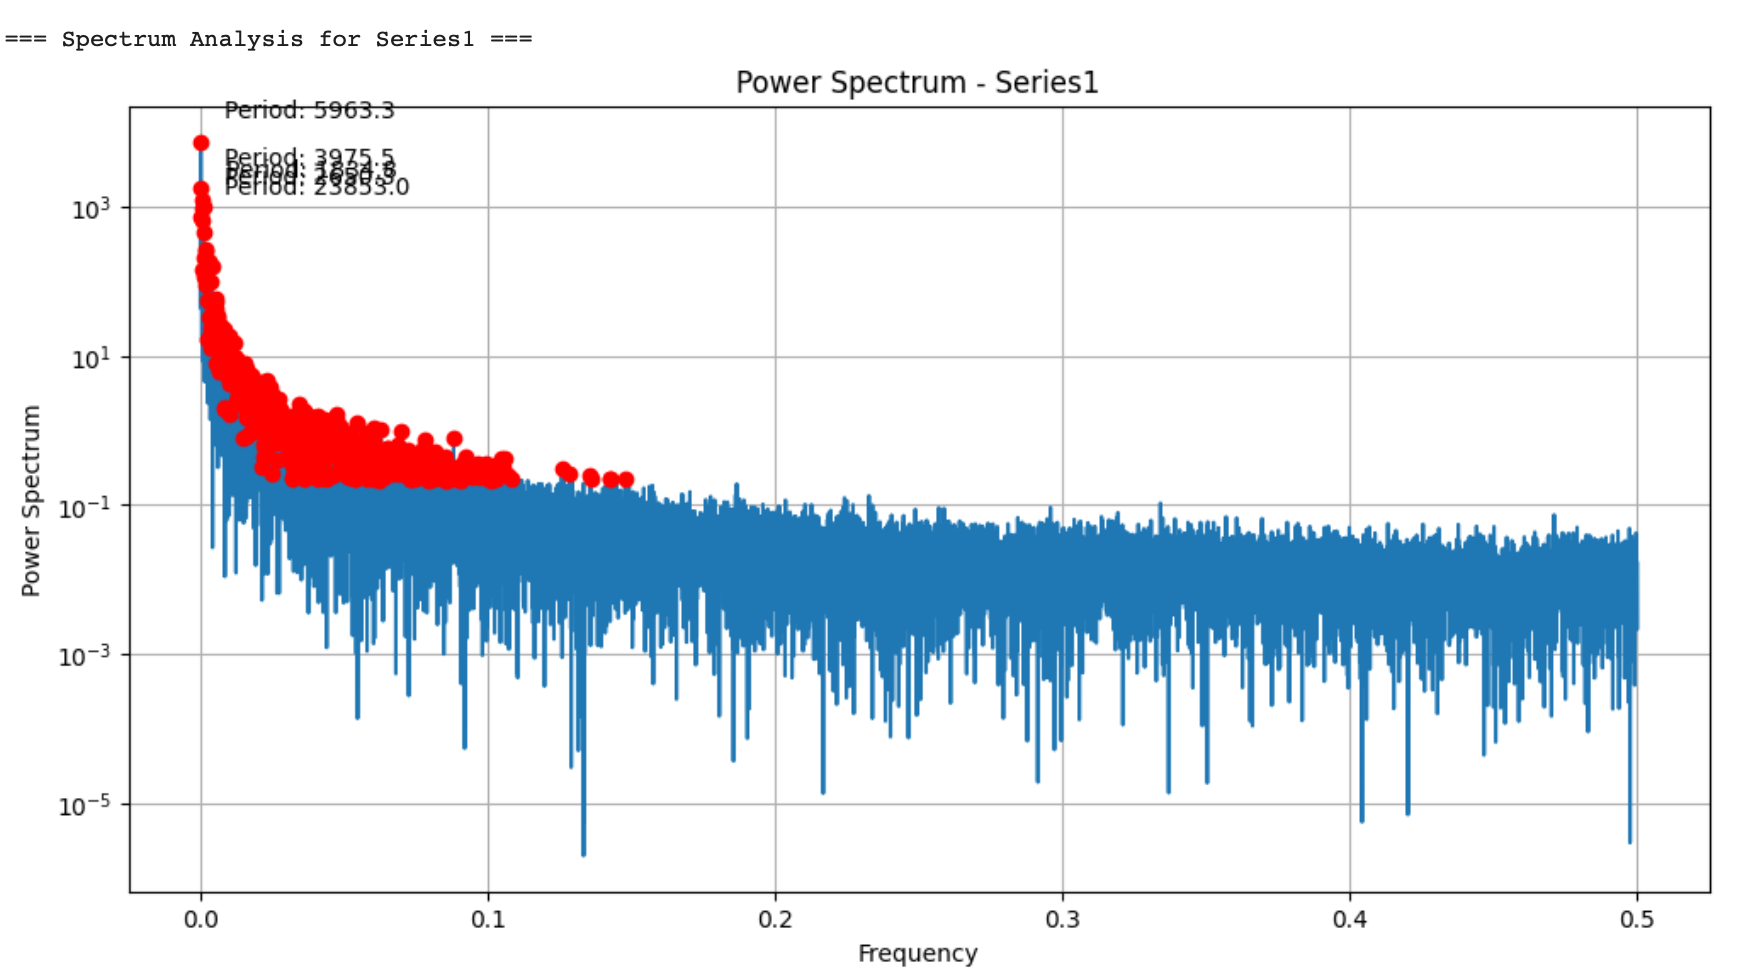

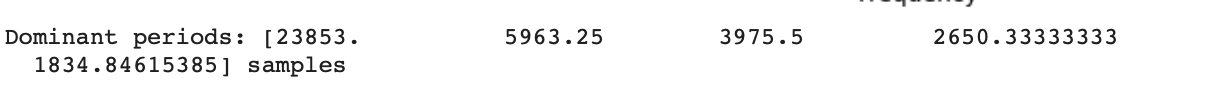